# Modeling - ethereum - v2

# Setup

## Library import
We import all the required Python libraries

In [1]:
import os

# Data manipulation
from feature_engine.encoding import RareLabelEncoder, CountFrequencyEncoder
import pandas as pd
from pandas.api.types import is_numeric_dtype
import numpy as np

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMClassifier
import missingno as msno
from pycaret.classification import ClassificationExperiment
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, HalvingGridSearchCV, cross_validate
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import set_config

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Options for pandas
set_config(transform_output = "pandas")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', '{:.5f}'.format)
# pd.options.display.float_format = '{:.5f}'.format
# pd.options.display.max_rows = 120

sns.set_context(context='paper', font_scale=1, rc=None)
sns.set_style("ticks")
sns.set_palette(sns.color_palette())

## Local library import
We import all the required local libraries libraries

In [168]:
os.chdir('../')
from src.utils.data_describe import breve_descricao, serie_nulos, cardinalidade, check_for_equal_columns
os.chdir('./notebooks/')

def round_4(x):
    return x.round(4)

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [3]:
RAW_FOLDER = '../data/raw/'
INTERIM_FOLDER = '../data/interim/'
PROCESSED_FOLDER = '../data/processed/'
REPORTS_FOLDER = '../reports/'
RANDOM_STATE = 42

train_size = 0.15

# Experience 01 - Only numerical attributes

## Data import

In [4]:
df_train_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'df_train_exp_01.pqt')
df_test_exp_01 = pd.read_parquet(INTERIM_FOLDER + 'df_test_exp_01.pqt')

display(df_train_exp_01.head(3))

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31000,34.12000,4815.43000,3,13,0,10,3,1.00000,2.50105,1.34844,1.00087,11.27787,5.84292,16,17.52875,17.52978,0.00104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50000,834.77000,9622.53000,2,2,0,1,2,0.58627,0.94751,0.76689,0.58541,0.94728,0.76635,4,1.53269,1.53378,0.00109,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90000,31.87000,321.42000,2,3,0,3,1,0.00102,0.81780,0.43961,0.50039,0.81751,0.65895,5,1.31790,1.31882,0.00092,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,1.33700,1.33700,1.33700,0.00000,0.00000,0.00000,0.00000,1.00000


# Light Gradient Boosting - Categorical features encoded by frequency

## Data import

In [7]:
df_raw = pd.read_parquet(INTERIM_FOLDER + 'ethereum_complete.pqt')

df_train_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_cleaned_train_exp_02_transformed.pqt')
df_test_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_cleaned_test_exp_02_transformed.pqt')

X_train_exp_02 = df_train_exp_02.drop(columns=['FLAG'])
y_train_exp_02 = df_train_exp_02[['FLAG']]

X_test_exp_02 = df_test_exp_02.drop(columns=['FLAG'])
y_test_exp_02 = df_test_exp_02[['FLAG']]

display(X_train_exp_02.head(3))

,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
3691,67691.12000,0.00000,135382.23000,2,1,0,1,2,0.70927,0.70927,0.70927,0.10700,0.29554,0.20127,3,0.40254,0.70927,0.30673,7.00000,139.77633,0.00000,0.00000,0.00000,5.00000,7.00000,0.00000,0.00000,77.37208,19.96805,0.00000,0.00000,0.00000,0.00000,7.00000,0.89006,0.31874
152,23488.73000,33.36000,48178.53000,2,36,0,26,2,0.01038,9.99000,1.33005,0.07579,48.30435,24.19007,38,48.38014,47.88187,-0.49828,2.00000,1.33700,0.00000,0.00000,0.00000,2.00000,2.00000,0.00000,0.00000,1.33700,0.66850,0.00000,0.00000,0.00000,0.00000,2.00000,0.89006,0.16704
1175,0.00000,0.00000,0.00000,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0,0.00000,0.00000,0.00000,1.00000,1.33700,0.00000,0.00000,0.00000,1.00000,1.00000,0.00000,0.00000,1.33700,0.86644,0.00000,0.00000,0.00000,0.00000,1.00000,0.89006,0.51421


## Random search

In [106]:
# Search space for the random search step 

max_depth = np.arange(3, 36, 5).tolist()
num_leaves = np.arange(2**min(max_depth), 70, 5).tolist()

dct_params = dict(
#     boosting_type = ['gbdt', 'dart', 'rf'],
    max_depth = max_depth,
    num_leaves = num_leaves,
    learning_rate = [0.0001, 0.001, 0.01, 0.1],
    n_estimators = np.arange(50, 600, 100).tolist(),
)

dct_params

{'max_depth': [3, 8, 13, 18, 23, 28, 33],
 'num_leaves': [8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68],
 'learning_rate': [0.0001, 0.001, 0.01, 0.1],
 'n_estimators': [50, 150, 250, 350, 450, 550]}

In [107]:
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent = 'warn', objective = 'binary', importance_type = 'split',
)

rscv = RandomizedSearchCV(
    classifier_lgbm, dct_params, error_score='raise', random_state=RANDOM_STATE, n_iter=100,
    return_train_score=True, scoring='roc_auc', cv=10, 
)

search = rscv.fit(X_train_exp_02, y_train_exp_02)

best_rscv = search.best_params_
best_rscv

{'num_leaves': 28, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1}

In [109]:
df_random_search_results = pd.DataFrame.from_dict(rscv.cv_results_, orient='columns')[
    ['rank_test_score', 'param_num_leaves', 'param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score',
     'mean_train_score', 'std_train_score']
]

df_random_search_results.sort_values(by=['rank_test_score'], ascending=True)[:10]

,rank_test_score,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,mean_train_score,std_train_score
38,1,28,250,3,0.10000,0.08864,0.01283,0.00402,0.00051,0.99885,0.00083,1.00000,0.00000
9,2,53,450,23,0.10000,0.38541,0.01388,0.00503,0.00074,0.99884,0.00064,1.00000,0.00000
33,3,18,250,23,0.10000,0.21531,0.02710,0.00437,0.00080,0.99879,0.00080,1.00000,0.00000
91,4,13,450,33,0.10000,0.33809,0.01968,0.00598,0.00053,0.99877,0.00082,1.00000,0.00000
73,5,28,250,23,0.10000,0.35675,0.04153,0.00535,0.00067,0.99876,0.00062,1.00000,0.00000
52,6,48,550,8,0.10000,0.48159,0.02078,0.00644,0.00113,0.99876,0.00073,1.00000,0.00000
92,7,23,250,18,0.10000,0.29295,0.01889,0.00491,0.00043,0.99875,0.00071,1.00000,0.00000
50,8,23,550,33,0.10000,0.41180,0.04371,0.00581,0.00064,0.99875,0.00066,1.00000,0.00000
5,9,28,150,28,0.10000,0.15215,0.00771,0.00382,0.00057,0.99874,0.00067,1.00000,0.00000
75,10,63,450,8,0.10000,0.54401,0.03668,0.00657,0.00094,0.99868,0.00088,1.00000,0.00000


### mean_test_score vs n_estimators vs param_learning_rate

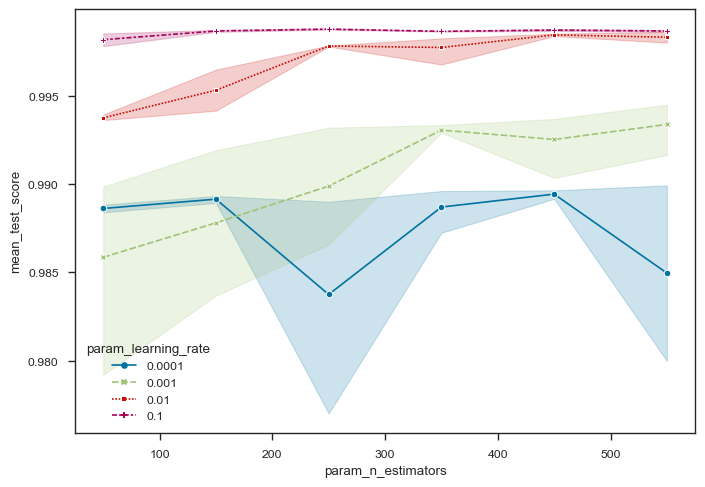

In [116]:
sns.lineplot(
    data=df_random_search_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate',
    palette=sns.color_palette(), style="param_learning_rate", markers=True
);

### mean_test_score vs param_num_leaves vs param_learning_rate

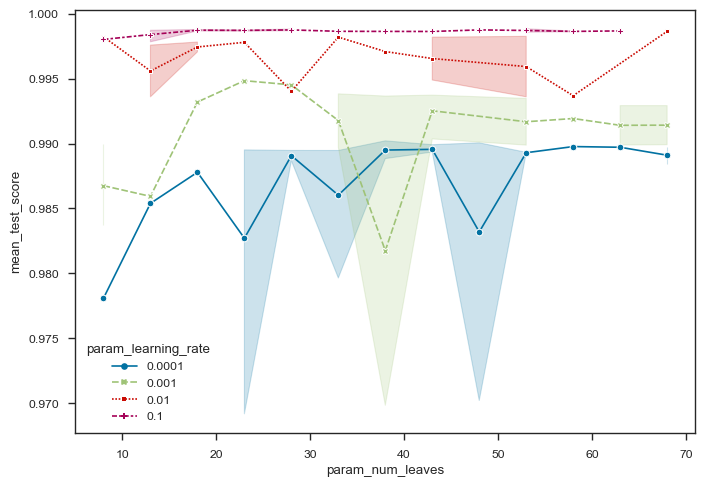

In [115]:
sns.lineplot(
    data=df_random_search_results, x='param_num_leaves', y='mean_test_score', hue='param_learning_rate',
    palette=sns.color_palette(), style="param_learning_rate", markers=True
);

### mean_test_score vs param_max_depth vs param_learning_rate

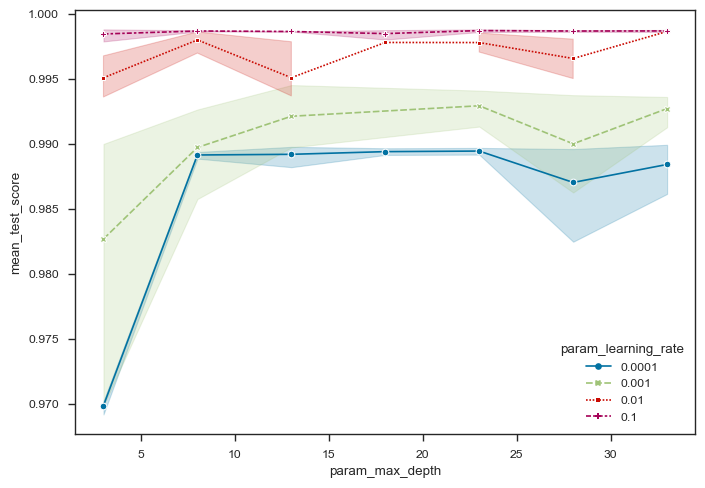

In [117]:
sns.lineplot(
    data=df_random_search_results, x='param_max_depth', y='mean_test_score', hue='param_learning_rate',
    palette=sns.color_palette(), style="param_learning_rate", markers=True
);

### For param_learning_rate = 0.1

#### mean_test_score vs param_max_depth vs param_num_leaves

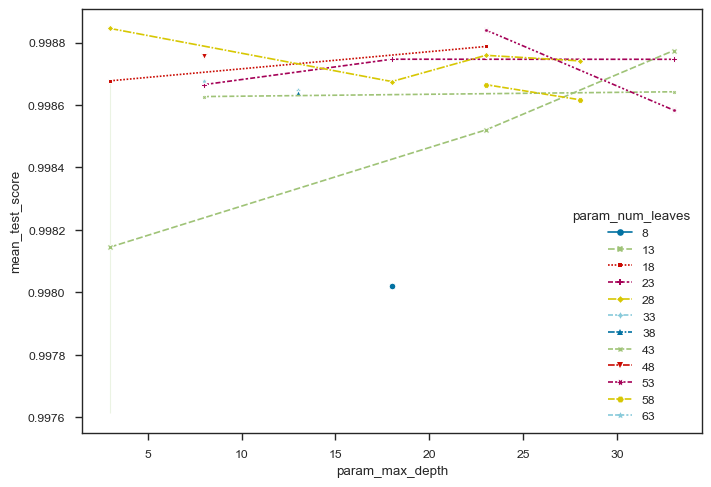

In [118]:
sns.lineplot(
    data=df_random_search_results.loc[df_random_search_results['param_learning_rate']==0.1, :],
    x='param_max_depth', y='mean_test_score', hue='param_num_leaves',
    palette=sns.color_palette(), style="param_num_leaves", markers=True
);

#### mean_test_score vs param_max_depth vs param_n_estimators

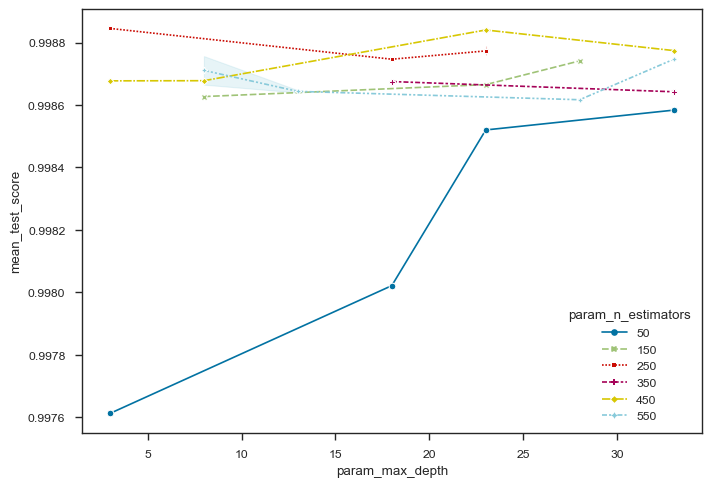

In [120]:
sns.lineplot(
    data=df_random_search_results.loc[df_random_search_results['param_learning_rate']==0.07500000000000001, :],
    x='param_max_depth', y='mean_test_score', hue='param_n_estimators',
    palette=sns.color_palette(), style="param_n_estimators", markers=True
);

## Grid search

In [133]:
dct_params = dict(
    max_depth=np.arange(max(best_rscv['max_depth']-2, 2), best_rscv['max_depth']+3, 1),
    num_leaves=np.arange(best_rscv['num_leaves']-2, 2**(best_rscv['max_depth']+3), 5),
    n_estimators = np.arange(best_rscv['n_estimators']-50, best_rscv['n_estimators']+50, 25).tolist(),
    learning_rate=np.arange(
        best_rscv['learning_rate']*.5, best_rscv['learning_rate']*1.5,
        best_rscv['learning_rate'] / 4
    )
)

dct_params

{'max_depth': array([2, 3, 4, 5]),
 'num_leaves': array([26, 31, 36, 41, 46, 51, 56, 61]),
 'n_estimators': [200, 225, 250, 275],
 'learning_rate': array([0.05 , 0.075, 0.1  , 0.125, 0.15 ])}

In [134]:
classifier_lgbm = LGBMClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='split',
)

gscv = GridSearchCV(
    classifier_lgbm, dct_params, error_score='raise',
    return_train_score=True, scoring='roc_auc', cv=10, n_jobs=-1
)

grid_search = gscv.fit(X_train_exp_02, y_train_exp_02)
best_gscv = grid_search.best_params_
best_gscv

{'learning_rate': 0.07500000000000001,
 'max_depth': 4,
 'n_estimators': 275,
 'num_leaves': 26}

In [169]:
df_grid_search_results = pd.DataFrame.from_dict(gscv.cv_results_, orient='columns')[
    ['rank_test_score', 'param_num_leaves', 'param_n_estimators', 'param_max_depth', 'param_learning_rate',
     'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'mean_test_score', 'std_test_score',
     'mean_train_score', 'std_train_score']
]

# Rounding df
df_grid_search_results['param_learning_rate'] = df_grid_search_results['param_learning_rate'].apply(round_4)

df_grid_search_results.sort_values(by=['rank_test_score'], ascending=True)[:10]

,rank_test_score,param_num_leaves,param_n_estimators,param_max_depth,param_learning_rate,mean_fit_time,std_fit_time,mean_score_time,std_score_time,mean_test_score,std_test_score,mean_train_score,std_train_score
223,1,61,275,4,0.07500,0.41166,0.02375,0.00943,0.00080,0.99889,0.00079,1.00000,0.00000
216,1,26,275,4,0.07500,0.47169,0.05970,0.01121,0.00299,0.99889,0.00079,1.00000,0.00000
217,1,31,275,4,0.07500,0.40998,0.01742,0.00979,0.00091,0.99889,0.00079,1.00000,0.00000
218,1,36,275,4,0.07500,0.39362,0.02210,0.01042,0.00183,0.99889,0.00079,1.00000,0.00000
222,1,56,275,4,0.07500,0.38721,0.01324,0.00972,0.00095,0.99889,0.00079,1.00000,0.00000
220,1,46,275,4,0.07500,0.40002,0.02670,0.00954,0.00064,0.99889,0.00079,1.00000,0.00000
221,1,51,275,4,0.07500,0.38540,0.01726,0.00940,0.00085,0.99889,0.00079,1.00000,0.00000
219,1,41,275,4,0.07500,0.39873,0.01792,0.00953,0.00127,0.99889,0.00079,1.00000,0.00000
198,9,56,200,4,0.07500,0.35219,0.03134,0.00798,0.00112,0.99888,0.00073,1.00000,0.00000
197,9,51,200,4,0.07500,0.39341,0.04086,0.00806,0.00068,0.99888,0.00073,1.00000,0.00000


### mean_test_score vs n_estimators vs param_learning_rate

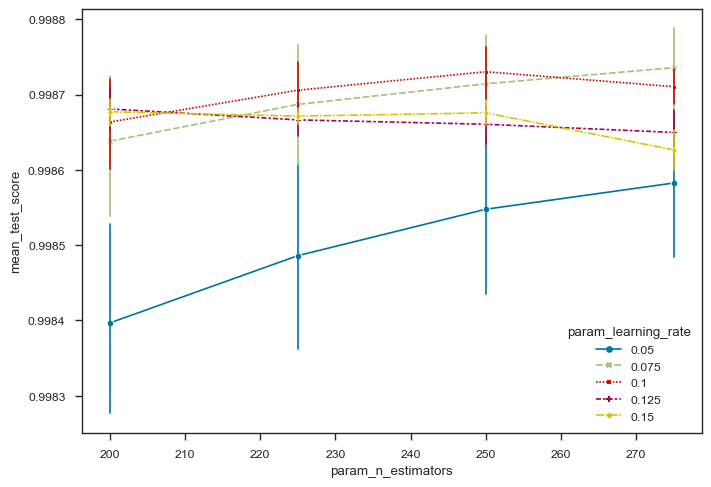

In [180]:
sns.lineplot(
    data=df_grid_search_results, x='param_n_estimators', y='mean_test_score', hue='param_learning_rate',
    palette=sns.color_palette(), style="param_learning_rate", markers=True, errorbar=('ci', 90), err_style='bars'
);

### mean_test_score vs param_num_leaves vs param_learning_rate

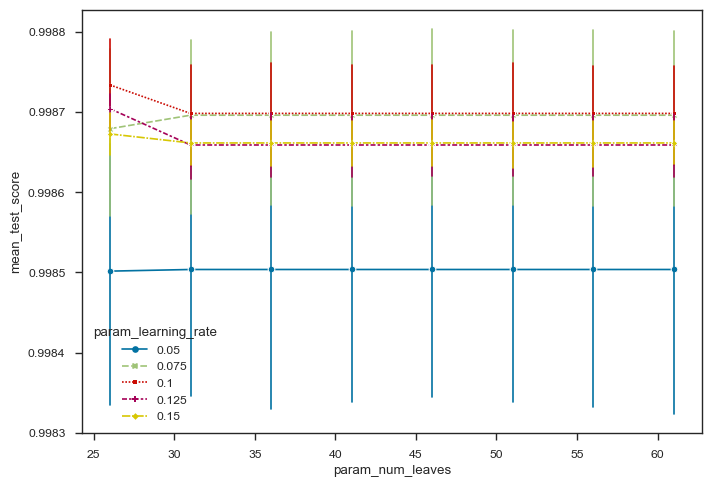

In [181]:
sns.lineplot(
    data=df_grid_search_results, x='param_num_leaves', y='mean_test_score', hue='param_learning_rate',
    palette=sns.color_palette(), style="param_learning_rate", markers=True, errorbar=('ci', 90), err_style='bars'
);

### mean_test_score vs param_max_depth vs param_learning_rate

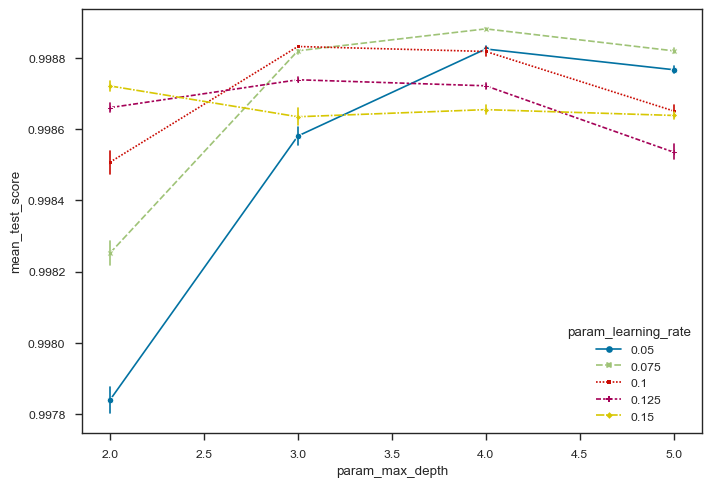

In [182]:
sns.lineplot(
    data=df_grid_search_results, x='param_max_depth', y='mean_test_score', hue='param_learning_rate',
    palette=sns.color_palette(), style="param_learning_rate", markers=True, errorbar=('ci', 90), err_style='bars'
);

### For param_learning_rate = 0.0750

#### mean_test_score vs param_max_depth vs param_num_leaves

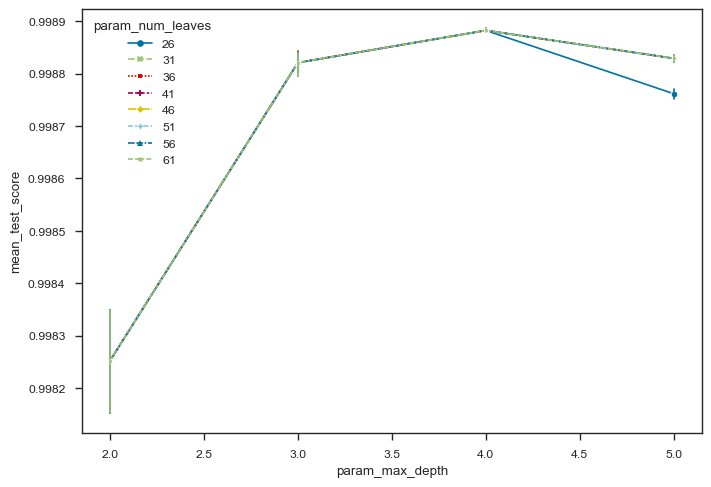

In [185]:
sns.lineplot(
    data=df_grid_search_results.loc[df_grid_search_results['param_learning_rate']==0.075, :],
    x='param_max_depth', y='mean_test_score', hue='param_num_leaves', errorbar=('ci', 90), err_style='bars',
    palette=sns.color_palette(), style="param_num_leaves", markers=True
);

#### mean_test_score vs param_max_depth vs param_n_estimators

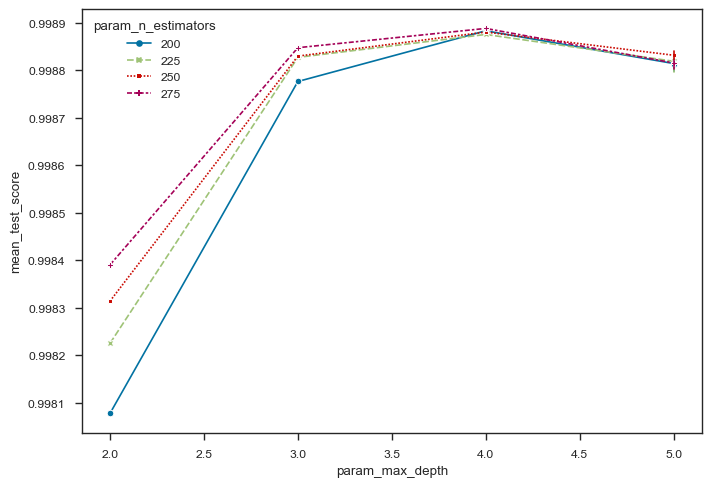

In [186]:
sns.lineplot(
    data=df_grid_search_results.loc[df_grid_search_results['param_learning_rate']==0.0750, :],
    x='param_max_depth', y='mean_test_score', hue='param_n_estimators', errorbar=('ci', 90), err_style='bars',
    palette=sns.color_palette(), style="param_n_estimators", markers=True
);

## AUC vs n_estimators vs depth - ESTOU NESSE PONTO

- 10-fold cross validation

In [208]:
# X_exp_02 = pd.concat([X_train_exp_02, X_test_exp_02], axis=0)
# y_exp_02 = pd.concat([y_train_exp_02, y_test_exp_02], axis=0)

X_exp_02 = X_train_exp_02.copy()
y_exp_02 = y_train_exp_02.copy()

In [209]:
best_params = dict(
    random_state=RANDOM_STATE, n_jobs=-1, silent='warn', objective='binary', importance_type='split',
    learning_rate=best_gscv['learning_rate'], num_leaves=best_gscv['num_leaves']
)

best_params

{'random_state': 42,
 'n_jobs': -1,
 'silent': 'warn',
 'objective': 'binary',
 'importance_type': 'split',
 'learning_rate': 0.075,
 'num_leaves': 26}

In [220]:
scoring='roc_auc'
dct_results = {}

for n_estimator in np.arange(75, 500, 25).tolist():
# for n_estimator in [100]:
    for depth in [2, 3, 4, 5, 13, 23, 33]:
        classifier_lgbm = LGBMClassifier(
            **best_params, n_estimators=n_estimator, max_depth=depth
        )

        cross = cross_validate(
            estimator=classifier_lgbm, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
            n_jobs=-1, verbose=0, return_train_score=True, 
        )

        dct_results[str(n_estimator)+'_'+str(depth)] = {
            'n_estimator': n_estimator,
            'depth': depth,
            'test_score_mean': cross['test_score'].mean(),
            'test_score_std': cross['test_score'].std(),
            'train_score_mean': cross['train_score'].mean(),
            'train_score_std': cross['train_score'].std()
        }

df_results = pd.DataFrame.from_dict(dct_results, orient='index')

df_results.sort_values(by='test_score_mean', ascending=False).head()

,n_estimator,depth,test_score_mean,test_score_std,train_score_mean,train_score_std
275_4,275,4,0.99889,0.00079,1.00000,0.00000
200_4,200,4,0.99888,0.00073,1.00000,0.00000
250_4,250,4,0.99888,0.00076,1.00000,0.00000
225_4,225,4,0.99888,0.00075,1.00000,0.00000
300_4,300,4,0.99885,0.00080,1.00000,0.00000


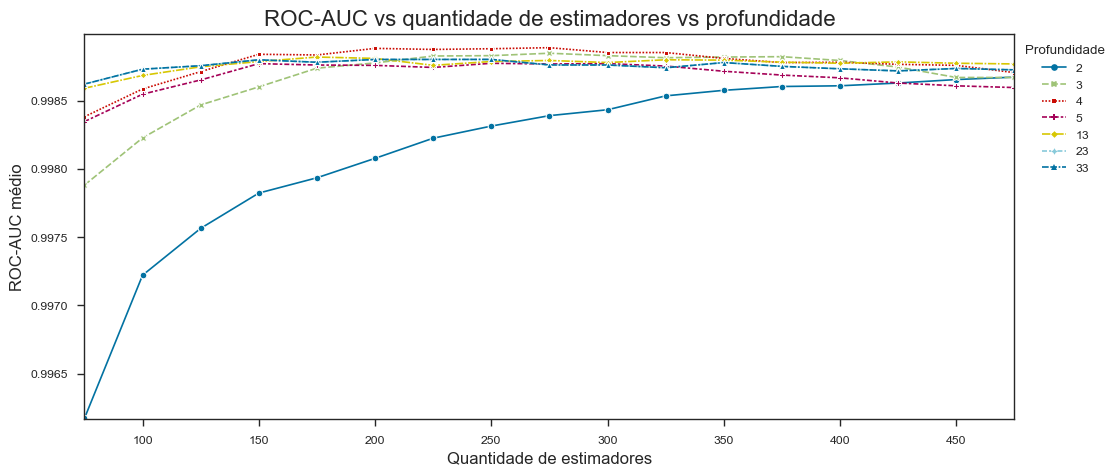

In [240]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results, x='n_estimator', y='test_score_mean', hue='depth', palette=sns.color_palette(),
    style="depth", markers=True
)

ax.set_title("ROC-AUC vs quantidade de estimadores vs profundidade", fontsize=16)
ax.set_xlabel("Quantidade de estimadores", fontsize=12)
ax.set_ylabel("ROC-AUC médio", fontsize=12)

plt.legend(title='Profundidade', fontsize=12)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(df_results['n_estimator'].min(), df_results['n_estimator'].max())
ax.set_ylim(df_results['test_score_mean'].min()*.999995, df_results['test_score_mean'].max()*1.0001);

## Log loss vs iterations vs train-test

In [213]:
lst_iterations = np.arange(0, 326, 1).tolist()
lst_iterations[0] = 1

In [214]:
scoring='neg_log_loss'
dct_results = {}
depth = best_gscv['max_depth']
n_estimator = 450


for n_estimator in lst_iterations:
    classifier_lgbm = LGBMClassifier(
            **best_params, n_estimators=n_estimator, max_depth=depth
        )
    
    cross = cross_validate(
        estimator=classifier_lgbm, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
        n_jobs=-1, verbose=0, return_train_score=True, 
    )

    dct_results[str(n_estimator)+'_'+str(depth)] = {
        'n_estimator': n_estimator,
        'test_score_mean': abs(cross['test_score'].mean()),
        'test_score_std': cross['test_score'].std(),
        'train_score_mean': abs(cross['train_score'].mean()),
        'train_score_std': cross['train_score'].std(),
    }

df_results = pd.DataFrame.from_dict(dct_results, orient='index')
df_results.head()

,n_estimator,test_score_mean,test_score_std,train_score_mean,train_score_std
1_4,1,0.63074,0.00095,0.62989,0.00030
2_4,2,0.57875,0.00194,0.57704,0.00058
3_4,3,0.53288,0.00287,0.53074,0.00076
4_4,4,0.49325,0.00353,0.49008,0.00094
5_4,5,0.45804,0.00417,0.45382,0.00101


In [215]:
df_results_melted = df_results[
    ['n_estimator','test_score_mean','train_score_mean']
].melt(['n_estimator'], var_name='scores', value_name='mean')

df_results_melted.sample(3, random_state=RANDOM_STATE)

,n_estimator,scores,mean
637,313,train_score_mean,0.00256
220,221,test_score_mean,0.04229
428,104,train_score_mean,0.02672


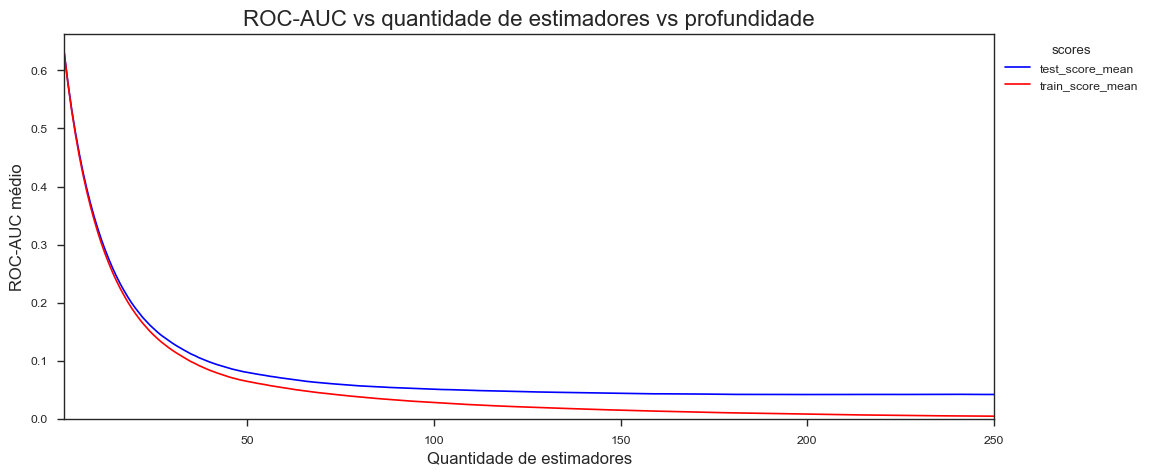

In [241]:
plt.figure(figsize=(12, 5))

ax = sns.lineplot(
    data=df_results_melted, x='n_estimator', y='mean', hue='scores', palette=['blue', 'red']
)

ax.set_title("ROC-AUC vs quantidade de estimadores vs profundidade", fontsize=16)
ax.set_xlabel("Quantidade de estimadores", fontsize=12)
ax.set_ylabel("ROC-AUC médio", fontsize=12)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(min(lst_iterations), 250)
ax.set_ylim(0, df_results_melted['mean'].max()*1.05);

In [64]:
df_results.sort_values(by=['test_score_mean'], ascending=False)

,n_estimator,test_score_mean,test_score_std,train_score_mean,train_score_std
1_6,1,0.64834,0.00068,0.64755,0.00030
2_6,2,0.61002,0.00133,0.60850,0.00055
3_6,3,0.57478,0.00200,0.57266,0.00059
4_6,4,0.54263,0.00279,0.53973,0.00062
5_6,5,0.51320,0.00332,0.50943,0.00052
...,...,...,...,...,...
181_6,181,0.04317,0.01111,0.00790,0.00039
198_6,198,0.04317,0.01161,0.00628,0.00036
192_6,192,0.04316,0.01126,0.00680,0.00034
193_6,193,0.04315,0.01131,0.00669,0.00035


# Random forest - Categorical features encoded by frequency

## Data import

In [ ]:
df_train_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_train_exp_02.pqt')
df_test_exp_02 = pd.read_parquet(INTERIM_FOLDER + 'df_test_exp_02.pqt')

X_train_exp_02 = df_train_exp_02.drop(columns=['Address', 'FLAG'])
y_train_exp_02 = df_train_exp_02[['FLAG']]

X_test_exp_02 = df_test_exp_02.drop(columns=['Address', 'FLAG'])
y_test_exp_02 = df_test_exp_02[['FLAG']]

display(X_train_exp_02.head(3))

## Random search

In [ ]:
classifier_rf = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, verbose=0
)

params = dict(
    n_estimators=np.arange(50, 600, 150).tolist(),
    criterion=['gini', 'entropy', 'log_loss'],
    max_depth=np.arange(4, 36, 4).tolist(),
    max_features=['sqrt', 'log2'],
    ccp_alpha=np.arange(0, 0.035, 0.005).tolist(),
)

rscv = RandomizedSearchCV(
    classifier_rf, params, error_score='raise', random_state=RANDOM_STATE, n_iter=100,
    return_train_score=True, scoring='roc_auc', cv=10
)

search = rscv.fit(X_train_exp_02, y_train_exp_02)
search.best_params_

In [ ]:
best_rscv = search.best_params_

## Grid search

In [ ]:
np.arange(int(best_rscv['max_depth']*.9), int(best_rscv['max_depth']*1.1), 1)

In [ ]:
classifier_rf = RandomForestClassifier(
    random_state=RANDOM_STATE, n_jobs=-1, verbose=0, **best_rscv
)

params = dict(
    n_estimators=np.arange(int(best_rscv['n_estimators']*.9), int(best_rscv['n_estimators']*1.1), 25).tolist(),
    max_depth=np.arange(int(best_rscv['max_depth']*.9), int(best_rscv['max_depth']*1.1), 1)
)

gscv = GridSearchCV(
    classifier_rf, params, error_score='raise',
    return_train_score=True, scoring='roc_auc', cv=10
)

grid_search = gscv.fit(X_train_exp_02, y_train_exp_02)
grid_search.best_params_

## AUC vs n_estimators vs depth

- 10-fold cross validation

In [ ]:
X_exp_02 = pd.concat([X_train_exp_02, X_test_exp_02], axis=0)
y_exp_02 = pd.concat([y_train_exp_02, y_test_exp_02], axis=0)

In [ ]:
best_params = {
    'max_features': 'sqrt', 'criterion': 'entropy', 'ccp_alpha': 0.0
}

In [ ]:
scoring='roc_auc'
dct_results = {}

for n_estimator in np.arange(100, 325, 25).tolist():
# for n_estimator in [100]:
    for depth in [6, 10, 14, 18]:
        classifier_rf = RandomForestClassifier(
            n_estimators=n_estimator, max_depth=depth, random_state=RANDOM_STATE, n_jobs=-1, verbose=0,
            max_features='sqrt', criterion='entropy', ccp_alpha=0.0
        )
        cross = cross_validate(
            estimator=classifier_rf, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
            n_jobs=-1, verbose=0, return_train_score=True, 
        )

        dct_results[str(n_estimator)+'_'+str(depth)] = {
            'n_estimator': n_estimator,
            'depth': depth,
            'test_score_mean': cross['test_score'].mean(),
            'test_score_std': cross['test_score'].std(),
            'train_score_mean': cross['train_score'].mean(),
            'train_score_std': cross['train_score'].std(),
        }

df_results = pd.DataFrame.from_dict(dct_results, orient='index')
df_results.head()

In [ ]:
plt.figure(figsize=(6, 4))

ax = sns.lineplot(
    df_results, x='n_estimator', y='test_score_mean', hue='depth', palette=sns.color_palette(),
    style="depth", markers=True
)
# plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(100, 300)
ax.set_ylim(0.99725, 0.9985);

## Log loss vs iterations vs train-test

In [ ]:
lst_iterations = np.arange(0, 326, 1).tolist()
lst_iterations[0] = 1

In [ ]:
scoring='neg_log_loss'
dct_results = {}
depth = 18

for n_estimator in lst_iterations:
    classifier_rf = RandomForestClassifier(
        n_estimators=n_estimator, max_depth=depth, random_state=RANDOM_STATE, n_jobs=-1, verbose=0,
        max_features='sqrt', criterion='entropy', ccp_alpha=0.0
    )
    cross = cross_validate(
        estimator=classifier_rf, X=X_exp_02, y=y_exp_02, scoring=scoring, cv=10,
        n_jobs=-1, verbose=0, return_train_score=True, 
    )

    dct_results[str(n_estimator)+'_'+str(depth)] = {
        'n_estimator': n_estimator,
        'test_score_mean': abs(cross['test_score'].mean()),
        'test_score_std': cross['test_score'].std(),
        'train_score_mean': abs(cross['train_score'].mean()),
        'train_score_std': cross['train_score'].std(),
    }

df_results = pd.DataFrame.from_dict(dct_results, orient='index')
df_results.head()

In [ ]:
df_results_melted = df_results[
    ['n_estimator','test_score_mean','train_score_mean']
].melt(['n_estimator'], var_name='scores', value_name='mean')

df_results_melted.head()

In [ ]:
plt.figure(figsize=(6, 4))

ax = sns.lineplot(
    df_results_melted, x='n_estimator', y='mean', hue='scores', palette=['blue', 'red']
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlim(min(lst_iterations), 15)
ax.set_ylim(0, df_results_melted['mean'].max()*1.05);